# PROJET 5 - Etude de marché

In [321]:
#import modules
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
%matplotlib inline
import statsmodels.api as sm
import seaborn as sns
import math
from sklearn import decomposition
from sklearn import preprocessing
import re

pd.set_option('display.max_rows', 170)

In [322]:
#fonctions analyse exploratoire
from matplotlib.collections import LineCollection
from scipy.cluster.hierarchy import dendrogram

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des pays (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

def plot_dendrogram(Z, names):
    plt.figure(figsize=(10,25))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('distance')
    dendrogram(
        Z,
        labels = names,
        orientation = "left",
        color_threshold = 11.5
    )
    plt.savefig('P5_01_dendrogramme.png')
    plt.show()

## Import et préparation des données

In [323]:
#IMPORT DONNEES

#table de correspondance pays (differents codes et noms pays selon les sources)
table_pays = pd.read_csv('donnees/table_pays.txt', sep = '\t')
table_pays.rename(columns = {'FAOSTAT': 'Code pays'}, inplace = True)


#tarifs douaniers / on prend la derniere année avec des données en remontant au maximum 10 ans
douane = pd.read_csv('donnees/WB_average_tariff.csv', sep = ',', header = 2 )
del douane['2019']
del douane['Unnamed: 64']
douane['last_value'] = douane.ffill(axis=1, limit = 10).iloc[:, -1] #on récupère la derniere valeur non nulle
douane = douane[['Country Name', 'Country Code', 'last_value' ]]
douane.rename(columns = {'last_value': 'tarif_douanier_moyen', 'Country Code': 'ISO3'}, inplace = True)

#Pour les pays de l'UE, on remplace le taux par 0 car l'UE est une zone de libre échange
pays_ue = pd.read_csv('donnees/pays_ue.txt', sep = '\t') #liste pays UE
pays_ue.rename(columns = {'Alpha-3': 'ISO3'}, inplace = True)
douane.loc[douane['ISO3'].isin(pays_ue['ISO3']), 'tarif_douanier_moyen'] = 0


#disponibilités alimentaires en prot et en Kcal // on utilisera ce df comme base pour l'échantillon
bilans = pd.read_csv('donnees/FAO_dispo_prot_kcal.csv', sep = ',', header = 1)
bilans['Code pays'] = bilans['Unnamed: 0'].str.extract('.*\[(.*)\].*') #extraction Code pays FAO
bilans['Code pays'] = pd.to_numeric(bilans['Code pays'])
bilans = bilans[['Code pays', 'Unnamed: 0', 'Unnamed: 1', 'Unité', 'Valeur']]
bilans.rename(columns = {'Unnamed: 0': 'Pays', 'Unnamed: 1': 'Element'}, inplace = True)
bilans = bilans.pivot_table(values = 'Valeur', index = ['Code pays', 'Pays'], columns = 'Element')
bilans.reset_index(inplace = True)
bilans = bilans[~bilans['Code pays'].isin([96,128,41,214])] # on retire les provinces chinoises
bilans.rename(columns = {'Disponibilité alimentaire (Kcal/personne/jour)': 'dispo_kcal',
                         'Disponibilité de protéines en quantité (g/personne/jour)': 'dispo_prot'}, inplace = True)


#dispo en proteines animales
prot_animal = pd.read_csv('donnees/FAO_dispo_prot_animaux.csv', sep = ',', header = 1)
prot_animal['Code pays'] = prot_animal['Unnamed: 0'].str.extract('.*\[(.*)\].*') #extraction Code pays FAO
prot_animal['Code pays'] = pd.to_numeric(prot_animal['Code pays'])
prot_animal = prot_animal[['Code pays', 'Unnamed: 0', 'Unnamed: 1', 'Unité', 'Valeur']]
prot_animal.rename(columns = {'Unnamed: 0': 'Pays', 'Unnamed: 1': 'Element'}, inplace = True)
prot_animal = prot_animal.pivot_table(values = 'Valeur', index = ['Code pays', 'Pays'], columns = 'Element')
prot_animal.reset_index(inplace = True)
prot_animal = prot_animal[~prot_animal['Code pays'].isin([96,128,41,214])] # on retire les provinces chinoises
prot_animal.rename(columns = {'Disponibilité de protéines en quantité (g/personne/jour)': 'dispo_prot_animaux'}, inplace = True)

#population
population = pd.read_csv('donnees/FAO_population_2014_2017.csv', sep = ',', header = 1)
population['Code pays'] = population['Unnamed: 0'].str.extract('.*\[(.*)\].*') #extraction Code pays FAO
population['Code pays'] = pd.to_numeric(population['Code pays'])
population = population[['Code pays', 'Unnamed: 2', 'Valeur', 'Valeur.1']]
population.rename(columns = {'Unnamed: 0': 'Pays', 'Valeur': 'population_2014', 'Valeur.1': 'population'}, inplace = True)
population = population[~population['Code pays'].isin([96,128,41,214])] # on retire les provinces chinoises
population['croissance_pop'] = round((population['population'] -  population['population_2014']) / #taux de croissance de la population sur 3 ans entre 2014 et 2017
                                     population['population_2014'] * 100, 2)

#PIB/hab // valeurs en $ courants // on n'utilise pas le RNB pour l'instant
pib_hab_pays = pd.read_csv('donnees/FAO_pib_rnb_p_hab_2014_2017.csv', sep = ',', header = 1)
pib_hab_pays['Code pays'] = pib_hab_pays['Unnamed: 0'].str.extract('.*\[(.*)\].*') #extraction Code pays FAO
pib_hab_pays['Code pays'] = pd.to_numeric(pib_hab_pays['Code pays'])
pib_hab_pays = pib_hab_pays[pib_hab_pays['Unnamed: 2'] == 'Produit intérieur brut par habitant [22014]']
pib_hab_pays = pib_hab_pays[['Code pays', 'Unnamed: 0', 'Valeur', 'Valeur.1']]
pib_hab_pays.rename(columns = {'Unnamed: 0': 'Pays', 'Valeur': 'pib_p_hab_2014', 'Valeur.1': 'pib_p_hab'}, inplace = True)
pib_hab_pays = pib_hab_pays[~pib_hab_pays['Code pays'].isin([96,128,41,214])] # on retire les provinces chinoises

#PIB // valeur en dollars prix 2010
pib_pays = pd.read_csv('donnees/FAO_pib_2014_2017.csv', sep = ',', header = 1)
pib_pays['Code pays'] = pib_pays['Unnamed: 0'].str.extract('.*\[(.*)\].*') #extraction Code pays FAO
pib_pays['Code pays'] = pd.to_numeric(pib_pays['Code pays'])
pib_pays = pib_pays[['Code pays', 'Unnamed: 0', 'Valeur', 'Valeur.1']]
pib_pays.rename(columns = {'Unnamed: 0': 'Pays', 'Valeur': 'pib_2014', 'Valeur.1': 'pib'}, inplace = True)
pib_pays = pib_pays[~pib_pays['Code pays'].isin([96,128,41,214])] # on retire les provinces chinoises
pib_pays['croissance_pib'] = round((pib_pays['pib'] -  pib_pays['pib_2014']) / 
                                     pib_pays['pib_2014'] * 100, 2)

#Indice des prix à la consommation IPC pour l'alimentation
ipc_pays = pd.read_csv('donnees/FAO_IPC_alimentation_2014_2017.csv', sep = ',', header = 1)
ipc_pays['Code pays'] = ipc_pays['Unnamed: 0'].str.extract('.*\[(.*)\].*') #extraction Code pays FAO
ipc_pays['Code pays'] = pd.to_numeric(ipc_pays['Code pays'])
ipc_pays = ipc_pays[['Code pays', 'Unnamed: 0', 'Valeur', 'Valeur.1']]
ipc_pays.rename(columns = {'Unnamed: 0': 'Pays', 'Valeur': 'ipc_2014', 'Valeur.1': 'ipc'}, inplace = True)
ipc_pays = ipc_pays[~ipc_pays['Code pays'].isin([96,128,41,214])] # on retire les provinces chinoises
ipc_pays['inflation_alim'] = round((((ipc_pays['ipc']  /ipc_pays['ipc_2014']) ** (1/3)) - 1) * 100, 2) #inflation moyenne annuelle sur 3 ans

#importations de volailles
import_volailles = pd.read_csv('donnees/FAO_importations_2014_2017.csv', sep = ',', header = 1)
import_volailles['Code pays'] = import_volailles['Unnamed: 0'].str.extract('.*\[(.*)\].*') #extraction Code pays FAO
import_volailles['Code pays'] = pd.to_numeric(import_volailles['Code pays'])
import_volailles = import_volailles[['Code pays', 'Unnamed: 0', 'Valeur', 'Valeur.1']]
import_volailles.rename(columns = {'Unnamed: 0': 'Pays', 'Valeur': 'import_volailles_2014', 'Valeur.1': 'import_volailles'}, inplace = True)
import_volailles = import_volailles[~import_volailles['Code pays'].isin([96,128,41,214])] # on retire les provinces chinoises
import_volailles['croissance_import_volailles'] = round((import_volailles['import_volailles'] -  import_volailles['import_volailles_2014']) / 
                                     import_volailles['import_volailles_2014'] * 100, 2)

#indice de stabilité politique de la FAO
stabilite_pol = pd.read_csv('donnees/FAO_stabilite_politique.csv', sep = ',', header = 1)
stabilite_pol['Code pays'] = stabilite_pol['Unnamed: 0'].str.extract('.*\[(.*)\].*') #extraction Code pays FAO
stabilite_pol['Code pays'] = pd.to_numeric(stabilite_pol['Code pays'])
stabilite_pol = stabilite_pol[['Code pays', 'Unnamed: 0', 'Valeur']]
stabilite_pol.rename(columns = {'Unnamed: 0': 'Pays', 'Valeur': 'stabilite_pol'}, inplace = True)
stabilite_pol = stabilite_pol[~stabilite_pol['Code pays'].isin([96,128,41,214])] # on retire les provinces chinoises

#indicateur "ease of business" de la Banque Mondiale
ease_of_business = pd.read_csv('donnees/ease_of_business_2019.csv', sep = ',', header = 2)
ease_of_business = ease_of_business[['Country Name', 'Country Code', '2019']]
ease_of_business.rename(columns = {'Country Code': 'ISO3', '2019': 'ease_of_business'}, inplace = True)

#distance geographique à la France (indicateur cepii)
dist_geo = pd.read_excel('donnees/dist_cepii.xls')
dist_geo = dist_geo[dist_geo['iso_o'] == 'FRA'] #on selectionne France comme pays d'origine
dist_geo = dist_geo[['iso_d', 'dist']]
dist_geo.rename(columns = {'iso_d': 'ISO3','dist': 'dist_geo'}, inplace = True)
dist_geo['dist_geo'] = round(dist_geo['dist_geo'], 2)

#indice de corruption ("corruption perception index" 2017 de transparency.org)
corruption = pd.read_excel('donnees/corruption_2017.xlsx', header = 2)
corruption = corruption[['ISO3', 'Country', 'CPI Score 2017']]
corruption.rename(columns = {'CPI Score 2017': 'corruption_score'}, inplace = True)

## Création de l'échantillon et nettoyage des données

### Nettoyage et traitement :

- Chine : ajout manuel des codes ISO3 et ISO2 car le tableau des pays utilise le Code pays de la chine continentale et non la Chine complete
- On choisit de supprimer la Nouvelle Calédonie et la Polynésie Française qui font partie de la France (on retire évidemment la France)
- On ajoute manuellement les données de population pour le Laos et l'Ouzbekistan (pas de données FAO, on utilise celles de la Banque Mondiale) 

In [324]:
#On crée un échantillon 'data' avec toutes les variables

#on ajoute les différents code pays sur le df bilans qui est la base de notre échantillon
data = bilans.copy()
data.sort_values(by = 'Pays', inplace = True)
table_pays.rename(columns = {'FAOSTAT': 'Code pays'}, inplace = True)
data = pd.merge(data, table_pays[['Short name', 'ISO3','ISO2','Code pays']], how = 'left', on = 'Code pays')
data = data[['Code pays', 'ISO3', 'Pays', 'Short name', 'dispo_kcal', 'dispo_prot']]

#traitement
data.iloc[31,1] = 'CHN' #on rajoute les codes de la Chine
data.iloc[31,3] = 'Chine'

data
data = data[~data['Code pays'].isin([70, 153])] #on supprime la France, la polynésie francaise et la nouvelle calédonie

#on ajoute la variable dispo prot animale
data = pd.merge(data, prot_animal[['Code pays', 'dispo_prot_animaux']], how = 'left', on = 'Code pays')
data['part_prot_animale'] = round(data['dispo_prot_animaux'] / data['dispo_prot'] * 100, 2) #ajout colonne part de proteines d'origine animale
del data['dispo_prot_animaux'] 

#on ajoute les variables population et croissance_pop
data = pd.merge(data, population[['Code pays', 'population', 'croissance_pop']], how = 'left', on = 'Code pays')

#on ajoute la variable pib_p_hab
data = pd.merge(data, pib_hab_pays[['Code pays', 'pib_p_hab']], how = 'left', on = 'Code pays')
data['pib_p_hab'] = round(data['pib_p_hab'], 2)

#on ajoute la variable inflation_alim
data = pd.merge(data, ipc_pays[['Code pays', 'inflation_alim']], how = 'left', on = 'Code pays')

#on ajoute la variable import_volailles
data = pd.merge(data, import_volailles[['Code pays', 'import_volailles']], how = 'left', on = 'Code pays')

#on ajoute l'indice de stabilite politique
data = pd.merge(data, stabilite_pol[['Code pays', 'stabilite_pol']], how = 'left', on = 'Code pays')

#on ajoute ease_of_business
data = pd.merge(data, ease_of_business[['ISO3', 'ease_of_business']], how = 'left', on = 'ISO3')
data['ease_of_business'] = 189 - data['ease_of_business'] #on inverse les valeurs pour que les valeurs soient croissantes avec la facilité à faire du business

#on ajoute la distance à la France
data = pd.merge(data, dist_geo[['ISO3', 'dist_geo']], how = 'left', on = 'ISO3')

#on ajoute la variable corruption
data = pd.merge(data, corruption[['ISO3', 'corruption_score']], how = 'left', on = 'ISO3')
data['corruption_score'] = 100 - data['corruption_score']

#on ajoute la variable tarif_douanier
data = pd.merge(data, douane[['ISO3', 'tarif_douanier_moyen']], how = 'left', on = 'ISO3')

In [325]:
# on vérifie l'échantillon : recherche de valeurs abberantes, doublons, valeurs manquantes
data.describe()

,Code pays,dispo_kcal,dispo_prot,part_prot_animale,population,croissance_pop,pib_p_hab,inflation_alim,import_volailles,stabilite_pol,ease_of_business,dist_geo,corruption_score
count,167.000000,167.00000,167.000000,167.000000,1.650000e+02,165.000000,167.000000,151.000000,1.620000e+02,165.000000,164.000000,163.000000,161.000000
mean,128.329341,2855.51497,80.672635,42.057784,4.442010e+04,4.029333,13172.122754,3.566358,7.178688e+04,-0.086667,96.762195,5898.275276,56.434783
std,75.279355,458.98203,19.924945,15.752202,1.578346e+05,3.662958,18548.222354,6.354428,1.643837e+05,0.898927,53.403185,3761.903106,18.332956
min,1.000000,1758.00000,39.890000,8.910000,5.205000e+01,-4.240000,340.870000,-38.510000,0.000000e+00,-2.960000,1.000000,262.380000,11.000000
25%,66.500000,2510.50000,64.120000,28.675000,2.920850e+03,1.480000,1939.475000,0.885000,2.478500e+03,-0.620000,51.750000,3075.790000,45.000000
50%,122.000000,2866.00000,80.680000,43.110000,9.845320e+03,3.420000,5679.650000,2.140000,1.318850e+04,0.020000,97.000000,5582.500000,61.000000
75%,190.000000,3248.50000,95.285000,56.185000,3.110465e+04,6.740000,15455.420000,5.875000,5.319775e+04,0.640000,143.250000,8595.230000,70.000000
max,351.000000,3768.00000,141.010000,71.570000,1.452625e+06,15.860000,110003.250000,25.620000,1.362319e+06,1.590000,188.000000,19263.880000,85.000000


In [326]:
#doublons
doublons = data.duplicated(subset = ['Code pays'])
doublons[doublons == True]

Series([], dtype: bool)

In [327]:
data.head()

,Code pays,ISO3,Pays,Short name,dispo_kcal,dispo_prot,part_prot_animale,population,croissance_pop,pib_p_hab,inflation_alim,import_volailles,stabilite_pol,ease_of_business,dist_geo,corruption_score,tarif_douanier_moyen
0,2.0,AFG,Afghanistan [2],Afghanistan,2000.0,54.09,19.50,36296.11,8.77,605.56,3.71,28937.0,-2.78,16.0,5590.38,85.0,5.63
1,202.0,ZAF,Afrique du Sud [202],Afrique du Sud,2994.0,83.41,41.43,57009.76,4.52,6153.46,7.74,480346.0,-0.27,105.0,9353.55,57.0,4.32
2,3.0,ALB,Albanie [3],Albanie,3400.0,119.55,55.49,2884.17,-0.42,4445.13,4.13,34988.0,0.40,107.0,1603.53,62.0,1.02
3,4.0,DZA,Algérie [4],Algérie,3349.0,92.91,27.67,41389.19,6.33,4051.24,3.99,0.0,-0.96,32.0,1340.39,67.0,9.98
4,79.0,DEU,Allemagne [79],Allemagne,3556.0,104.20,60.54,82658.41,1.48,44642.74,1.97,474951.0,0.58,167.0,439.90,19.0,0


In [328]:
#lignes avec des valeurs manquantes
data[data.isnull().any(axis=1)]

,Code pays,ISO3,Pays,Short name,dispo_kcal,dispo_prot,part_prot_animale,population,croissance_pop,pib_p_hab,inflation_alim,import_volailles,stabilite_pol,ease_of_business,dist_geo,corruption_score,tarif_douanier_moyen
6,8.0,ATG,Antigua-et-Barbuda [8],Antigua-et-Barbuda,2430.0,81.45,66.37,95.43,3.10,14390.25,NaN,6144.0,0.76,76.0,6708.77,NaN,14.89
8,9.0,ARG,Argentine [9],Argentine,3239.0,102.71,63.96,43937.14,3.05,14517.29,NaN,2097.0,0.18,63.0,11072.25,61.0,7.42
13,12.0,BHS,Bahamas [12],Bahamas,2043.0,61.47,68.34,381.75,3.00,30732.42,NaN,20762.0,1.00,70.0,7209.45,35.0,17.05
17,23.0,BLZ,Belize [23],Belize,2698.0,67.18,37.88,375.77,6.34,4901.75,-0.41,3.0,0.05,54.0,8664.44,NaN,11.08
31,351.0,CHN,Chine [351],Chine,3194.0,101.35,39.90,1452625.24,1.53,8843.58,1.82,1362319.0,NaN,158.0,8225.23,59.0,3.39
37,49.0,CUB,Cuba [49],Cuba,3410.0,88.44,36.84,11339.25,0.29,8433.09,NaN,307421.0,0.69,NaN,7729.48,53.0,7.15
46,66.0,FJI,Fidji [66],Fidji,2937.0,73.93,42.22,877.46,1.27,5912.16,1.69,2362.0,0.79,87.0,16595.08,NaN,16.34
58,91.0,GUY,Guyana [91],Guyana,2885.0,87.87,44.29,775.22,1.55,4570.50,NaN,81.0,-0.04,55.0,7320.08,62.0,3.74
66,103.0,IRQ,Iraq [103],Iraq,2506.0,60.55,22.38,37552.78,9.13,4980.95,NaN,465572.0,-2.33,17.0,3867.43,82.0,NaN
69,105.0,ISR,Israël [105],Israël,3509.0,122.70,59.13,8243.85,4.96,42450.33,-0.31,NaN,-0.88,154.0,3281.90,38.0,1.85


In [329]:
#REMPLACEMENT VALEURS MANQUANTES

#ajout manuel des données de population pour LAO et UZB (source Banque Mondiale) (pop 2017 et croissance 2014-2017)
#UZB
data.iloc[109, 7] = 3239
data.iloc[109, 8] = round((3239/3076 -1) * 100, 2)
#LAO
data.iloc[125, 7] = 695.3
data.iloc[125, 8] = round((695.3/664 - 1) * 100, 2)

In [330]:
#on remplace les NaN de la colonne import_volailles par 0
data['import_volailles'].fillna(0, inplace = True)

In [331]:
#on remplace les NaN de la colonne stabilite_pol pour la Chine et la Namibie

#on se base sur le quantile de l'échantillon, en utilisant une autre étude de 
#la Banque Mondiale (Worldwide Governance Indicators 2014) qui donne pour La Chine un score de 62 et la Namibie 90

#Chine
data.iloc[31, 12] = data['stabilite_pol'].quantile(1 - 0.62)
#Namibie
data.iloc[100, 12] = data['stabilite_pol'].quantile(1 - 0.90)

In [332]:
# ease_of_business : on remplace les NaN pour Cuba, Corée du Nord et Turkmenistan par la valeur max (la moins bonne)
data['ease_of_business'].fillna(188, inplace = True)

In [333]:
# valeurs manquantes dist_geo
#on remplace les distances manquantes manuellement
data.iloc[97,14] = 1415 #Montenegro
data.iloc[118,14] = 1770 #Roumanie
data.iloc[133,14] = 1444 #Serbie
data.iloc[147,14] = 13253 #Timor Leste

In [334]:
#corruption_score : les valeurs manquantes ne concernent que quelques petits pays. On considère les nan comme dus à un manque 
#de données, et on les remplace par la mediane de l'échantillon
median_corruption_score = data['corruption_score'].median()
data['corruption_score'].fillna(median_corruption_score, inplace = True)

In [335]:
#inflation_alim
#il manque 16 valeurs, on décide par défaut d'utiliser la moyenne de l'échantillon pour combler les valeurs manquantes
mean_inflation = data['inflation_alim'].mean()
data['inflation_alim'].fillna(mean_inflation, inplace = True)

In [336]:
#douanes : 5 valeurs manquantes. On remplace par la moyenne de l'échantillon
mean_tarif_douanier_moyen = data['tarif_douanier_moyen'].mean()
data['tarif_douanier_moyen'].fillna(mean_tarif_douanier_moyen, inplace = True)

In [337]:
#on vérifie qu'il n'y a plus aucune valeur manquante
data[data.isnull().any(axis=1)]

,Code pays,ISO3,Pays,Short name,dispo_kcal,dispo_prot,part_prot_animale,population,croissance_pop,pib_p_hab,inflation_alim,import_volailles,stabilite_pol,ease_of_business,dist_geo,corruption_score,tarif_douanier_moyen


In [338]:
#ECHANTILLON FINAL

del data['Pays']
data.rename(columns = {'Short name': 'Pays'}, inplace = True)


liste_variables = ['dispo_kcal', 'dispo_prot', 'part_prot_animale', 'population','croissance_pop', 'pib_p_hab', 
             'inflation_alim', 'import_volailles','stabilite_pol', 'ease_of_business', 'dist_geo', 'corruption_score',
             'tarif_douanier_moyen'] #liste informative des variables disponibles 

data = data[['Pays','dispo_kcal', 'dispo_prot', 'part_prot_animale', 'population', 'croissance_pop', 'pib_p_hab', 
             'inflation_alim', 'import_volailles','stabilite_pol', 'ease_of_business', 'dist_geo', 'corruption_score',
             'tarif_douanier_moyen']] #variables choisies pour l'analyse

data.set_index('Pays', inplace = True)
data.drop('France',inplace = True) #On supprime le pays France
data.head()

,dispo_kcal,dispo_prot,part_prot_animale,population,croissance_pop,pib_p_hab,inflation_alim,import_volailles,stabilite_pol,ease_of_business,dist_geo,corruption_score,tarif_douanier_moyen
Pays,,,,,,,,,,,,,
Afghanistan,2000.0,54.09,19.50,36296.11,8.77,605.56,3.71,28937.0,-2.78,16.0,5590.38,85.0,5.63
Afrique du Sud,2994.0,83.41,41.43,57009.76,4.52,6153.46,7.74,480346.0,-0.27,105.0,9353.55,57.0,4.32
Albanie,3400.0,119.55,55.49,2884.17,-0.42,4445.13,4.13,34988.0,0.40,107.0,1603.53,62.0,1.02
Algérie,3349.0,92.91,27.67,41389.19,6.33,4051.24,3.99,0.0,-0.96,32.0,1340.39,67.0,9.98
Allemagne,3556.0,104.20,60.54,82658.41,1.48,44642.74,1.97,474951.0,0.58,167.0,439.90,19.0,0.00


## CLASSIFICATION HIERARCHIQUE

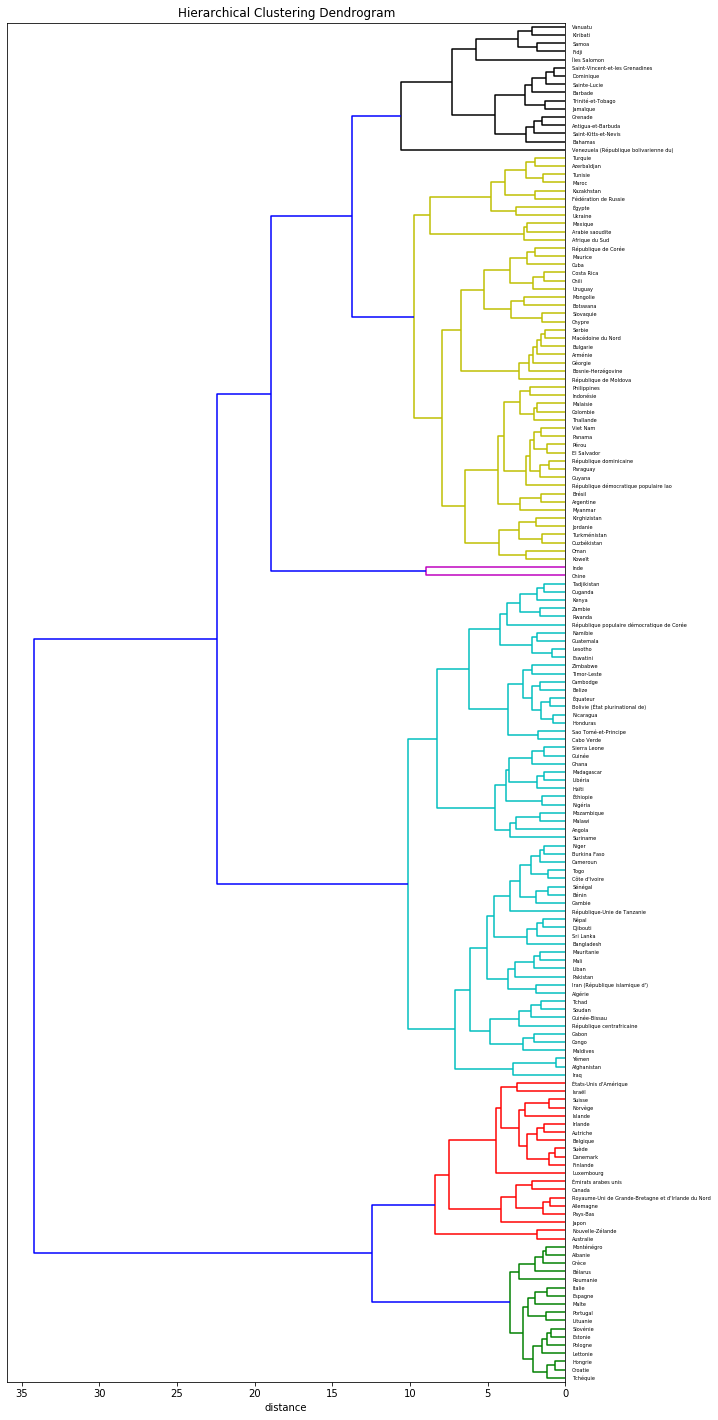

In [339]:
#CLASSIFICATION HIERARCHIQUE ET DENDROGRAMME
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn import preprocessing

# préparation des données pour le clustering
X = data.values
pays = data.index

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Clustering hiérarchique
Z = linkage(X_scaled, 'ward')

# Affichage du dendrogramme
plot_dendrogram(Z, pays)

#(export du dendogramme en jpg intégré à la fonction plot_dendrogram)

In [340]:
# Découpage du dendrogramme en 6 clusters (nombre à définir)
clusters = fcluster(Z, 6, criterion='maxclust')

#ajout du cluster à l'échantillon
data_cluster = data.copy()
data_cluster['Cluster'] = clusters

In [341]:
#affichage de l'échantillon avec en index les clusters
data_cluster.reset_index(inplace = True)
data_cluster.set_index(['Cluster','Pays'], inplace = True)
data_cluster.sort_values(by = 'Cluster', inplace = True)

#export des groupes de pays après découpage du dendogramme
pd.DataFrame(data_cluster.index).to_csv('P5_03_groupes_pays.csv')

data_cluster.head(170)

dispo_kcal  \
Cluster Pays                                                             
1       Lituanie                                                3419.0   
        Italie                                                  3522.0   
        Lettonie                                                3169.0   
        Hongrie                                                 3286.0   
        Malte                                                   3460.0   
        Grèce                                                   3355.0   
        Monténégro                                              3481.0   
        Estonie                                                 3245.0   
        Espagne                                                 3270.0   
        Pologne                                                 3525.0   
        Portugal                                                3492.0   
        Roumanie                                                3525.0   
        Bélarus                                                 3289.0   
        Slovénie                                                3195.0   
        Croatie                                                 3083.0   
        Tchéquie                                                3276.0   
        Albanie                                                 3400.0   
2       Royaume-Uni de Grande-Bretagne et d'Irlande du ...      3428.0   
        Pays-Bas                                                3249.0   
        Japon                                                   2697.0   
        Australie                                               3311.0   
        Autriche                                                3692.0   
        Nouvelle-Zélande                                        3156.0   
        Luxembourg                                              3335.0   
        Allemagne                                               3556.0   
        Canada                                                  3492.0   
        Norvège                                                 3385.0   
        Irlande                                                 3717.0   
        Islande                                                 3628.0   
        Israël                                                  3509.0   
        Suisse                                                  3413.0   
        États-Unis d'Amérique                                   3766.0   
        Suède                                                   3219.0   
        Finlande                                                3337.0   
        Belgique                                                3768.0   
        Émirats arabes unis                                     3366.0   
        Danemark                                                3384.0   
3       Maldives                                                2252.0   
        Mauritanie                                              2842.0   
        Mali                                                    2926.0   
        Tadjikistan                                             2104.0   
        Madagascar                                              1903.0   
        Zimbabwe                                                2173.0   
        Équateur                                                2586.0   
        Éthiopie                                                2304.0   
        Libéria                                                 2132.0   
        Liban                                                   2880.0   
        Lesotho                                                 2282.0   
        Malawi                                                  2647.0   
        Mozambique                                              2304.0   
        Yémen                                                   2063.0   
        Nicaragua                                               2629.0   
        Sénégal                                                 

In [342]:
#calcul des moyenne par cluster
data_cluster_gb = data_cluster.groupby(['Cluster']).mean()
data_cluster_gb

,dispo_kcal,dispo_prot,part_prot_animale,population,croissance_pop,pib_p_hab,inflation_alim,import_volailles,stabilite_pol,ease_of_business,dist_geo,corruption_score,tarif_douanier_moyen
Cluster,,,,,,,,,,,,,
1,3352.470588,104.695294,57.183529,1.364307e+04,-0.700000,17482.100000,1.717059,41649.117647,0.536471,142.000000,1464.270588,46.470588,0.337647
2,3420.400000,107.497500,59.762500,3.817822e+04,2.475000,56025.744500,0.877000,142721.600000,0.850000,165.500000,3920.652000,20.800000,1.022000
3,2457.590164,63.008197,26.860000,2.686771e+04,7.005574,2292.076885,5.786244,29294.409836,-0.715574,51.196721,6331.845246,69.245902,8.892064
4,2855.500000,83.340000,31.210000,1.395651e+06,2.425000,5401.900000,3.000000,681168.500000,-0.558400,142.000000,7409.730000,59.500000,4.135000
5,2987.760000,84.420000,44.814200,3.611148e+04,3.307600,8626.075400,3.969036,87961.960000,-0.160600,121.420000,6363.434200,60.160000,3.524519
6,2681.312500,74.955625,53.283125,2.319030e+03,2.416875,10096.442500,-0.591308,9096.125000,0.666875,67.125000,9780.206875,54.062500,12.873935


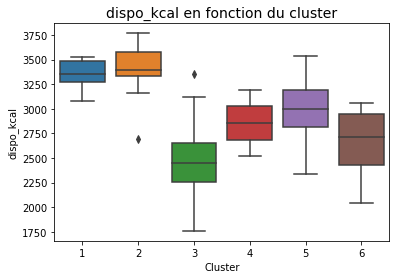

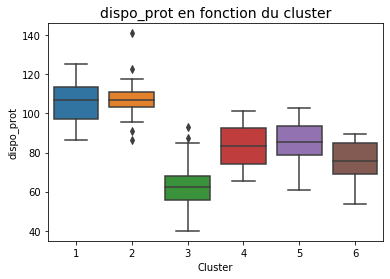

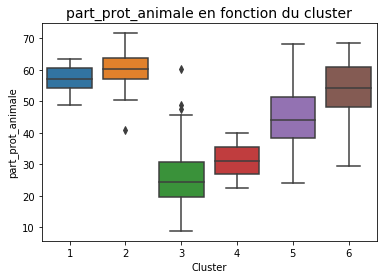

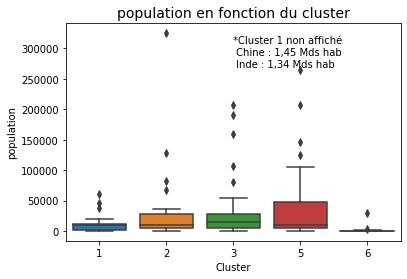

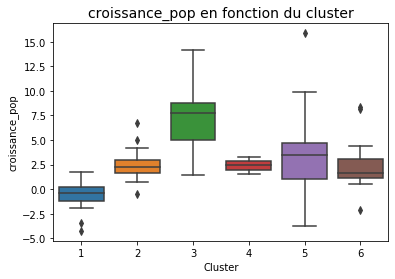

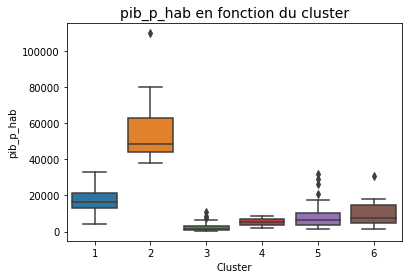

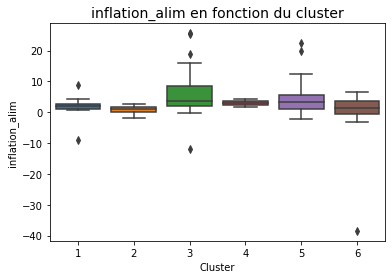

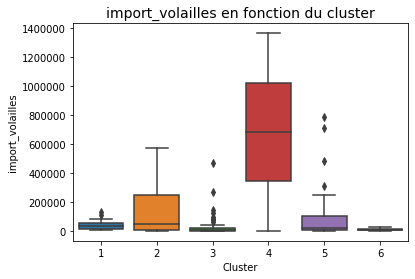

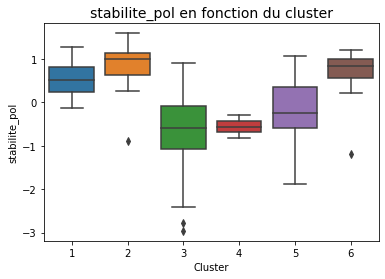

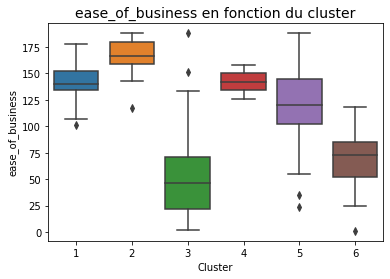

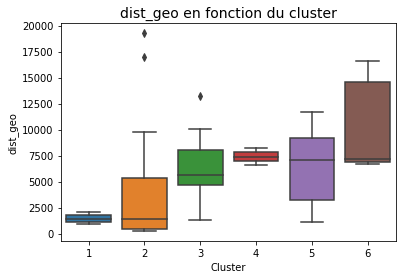

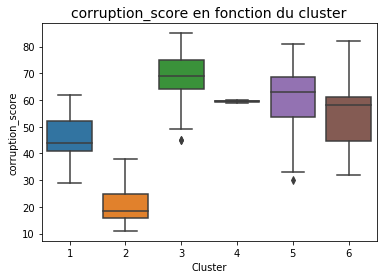

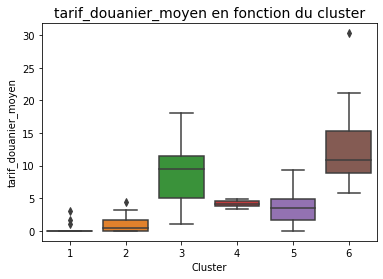

In [343]:
#Boxplot par cluster (1 boxplot par variable)

data_cluster.reset_index(inplace = True)

for c in data_cluster.columns[2:]:
    if c == 'population':
        fig, ax = plt.subplots()
        sns.boxplot(data = data_cluster[~data_cluster['Pays'].isin(['Chine','Inde'])], x = 'Cluster', y = c)
        plt.title(f'{c} en fonction du cluster', size = 14)
        plt.text(s = '*Cluster 1 non affiché\n Chine : 1,45 Mds hab\n Inde : 1,34 Mds hab', x = 2, y = 270000)
        
    else:
        fig, ax = plt.subplots()
        sns.boxplot(data = data_cluster, x = 'Cluster', y = c)
        plt.title(f'{c} en fonction du cluster', size = 14)

plt.show()

## ANALYSE EN COMPOSANTES PRINCIPALES

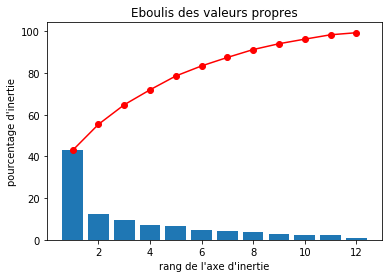

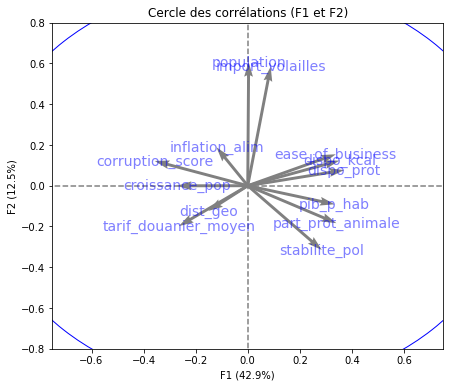

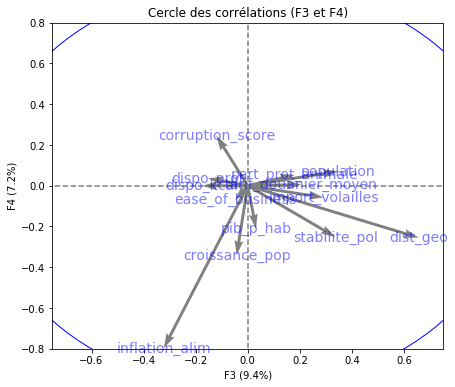

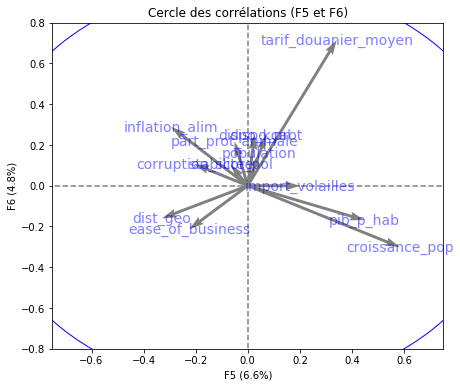

In [344]:
#ACP

# choix du nombre de composantes à calculer
n_comp = 12


# préparation des données pour l'ACP
X = data.values
features = data.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Eboulis des valeurs propres
display_scree_plot(pca)

# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5)], labels = features, lims = [-0.75, 0.75,-0.80,0.80])

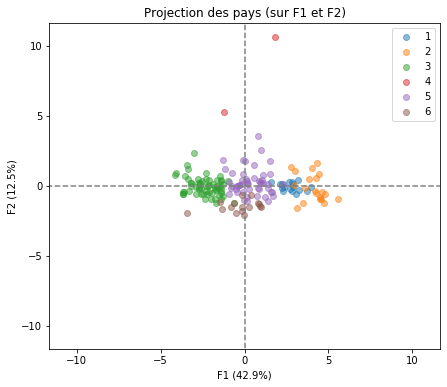

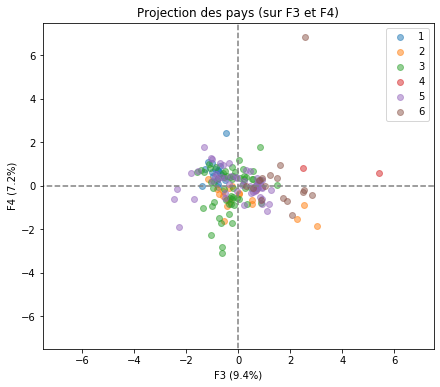

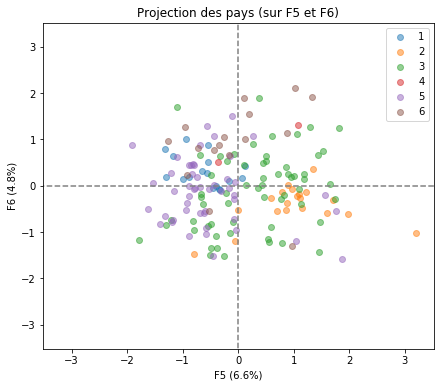

In [345]:
# Projection des individus sur les 3 premiers plans factoriels
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(4,5)], illustrative_var = clusters, alpha = 0.5)

plt.show()

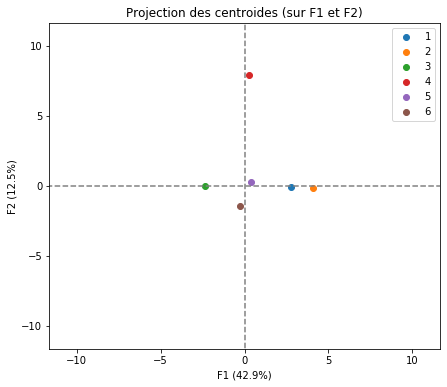

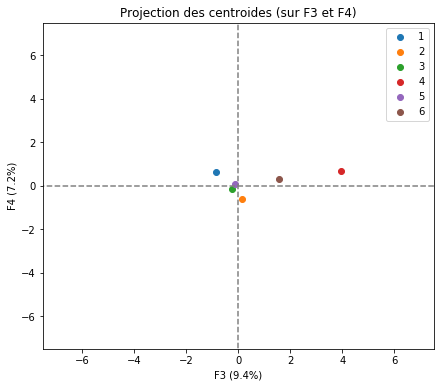

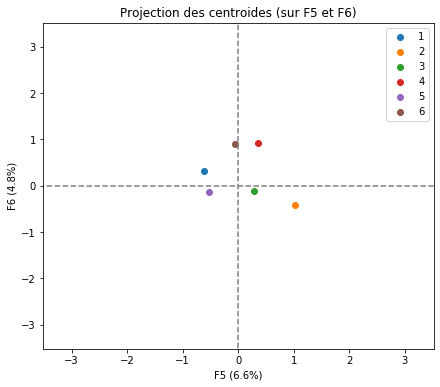

In [346]:
# Affichage centroides sur les plans factoriels

#calcul des centroides (moyenne des coordonnées des pays du cluster sur chaque plan factoriel)
centroids = pd.DataFrame(X_projected)
centroids['Cluster'] = clusters
centroids = centroids.groupby(['Cluster']).mean()
centroids = centroids.values

#affichage sur les 3 premiers plans factoriels
for d1,d2 in [(0,1),(2,3),(4,5)]:
    # initialisation de la figure       
    fig = plt.figure(figsize=(7,6))
        
    # affichage des points         
    illustrative_var = np.unique(clusters)
    for value in np.unique(illustrative_var):
        selected = np.where(illustrative_var == value)
        plt.scatter(centroids[selected, d1], centroids[selected, d2], alpha=1, label=value)
        plt.legend()
                
    # détermination des limites du graphique
    boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
    plt.xlim([-boundary,boundary])
    plt.ylim([-boundary,boundary])
        
    # affichage des lignes horizontales et verticales
    plt.plot([-100, 100], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-100, 100], color='grey', ls='--')

    # nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
    plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

    plt.title("Projection des centroides (sur F{} et F{})".format(d1+1, d2+1))
    plt.show(block=False)

In [347]:
#df des coordonnées des centroides à exporter en csv
df_centroides = pd.DataFrame(centroids)

#on renomme l'index et les colonnes
df_centroides.index.names = ['Cluster']
i = 1
for col in df_centroides.columns: 
    df_centroides.rename(columns={col: 'F' + str(i)}, inplace=True)
    i+= 1

df_centroides.to_csv ('P5_04_coordonnees_centroides.csv', index = False, header=True)    
df_centroides

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12
Cluster,,,,,,,,,,,,
0,2.760294,-0.059329,-0.866852,0.652280,-0.614345,0.317559,0.033794,-0.182658,-0.113169,0.409139,-0.041547,-0.073896
1,4.078820,-0.138283,0.148518,-0.618549,1.015037,-0.426209,0.206216,0.046340,-0.017058,-0.437200,-0.172378,0.076887
2,-2.349518,-0.043258,-0.244143,-0.143683,0.275077,-0.112657,0.099768,-0.083124,0.017297,-0.008541,-0.106394,0.007957
3,0.281245,7.930919,3.949034,0.683402,0.351429,0.914696,3.009136,0.753803,-0.517932,0.973482,0.092791,0.039642
4,0.373132,0.276989,-0.123364,0.076406,-0.526869,-0.125240,-0.322811,0.153554,0.039341,0.044521,0.202724,0.006453
5,-0.274991,-1.456145,1.558061,0.303739,-0.062249,0.901899,-0.041400,-0.121022,0.017419,-0.116459,0.020133,-0.073051


# K-means

In [348]:
#on effectue un kmeans sur le cluster choisi pour isoler 3 ou 4 pays 

#préparation données
cluster_choisi = data_cluster[data_cluster['Cluster'] == 2].copy()
print('Taille du cluster avant k-means:', cluster_choisi.shape[0],'pays')

liste_variables = ['dispo_kcal', 'dispo_prot', 'part_prot_animale', 'population','croissance_pop', 'pib_p_hab', 
             'inflation_alim', 'import_volailles','stabilite_pol', 'ease_of_business', 'dist_geo', 'corruption_score',
             'tarif_douanier_moyen'] #liste informative des variables disponibles 

#on definit les variables utilisées pour le k-means
cluster_choisi_k = cluster_choisi[['Pays','croissance_pop', 'import_volailles', 'dist_geo', 'inflation_alim', 'tarif_douanier_moyen']].copy()
cluster_choisi_k.set_index('Pays', inplace = True)
cluster_choisi_k

Taille du cluster avant k-means: 20 pays


,croissance_pop,import_volailles,dist_geo,inflation_alim,tarif_douanier_moyen
Pays,,,,,
Royaume-Uni de Grande-Bretagne et d'Irlande du Nord,1.99,366960.0,342.95,-0.03,0.00
Pays-Bas,0.76,358733.0,427.92,1.60,0.00
Japon,-0.52,569477.0,9725.63,2.61,2.45
Australie,4.19,3043.0,16975.46,0.26,0.86
Autriche,2.38,45022.0,1035.14,1.54,0.00
Nouvelle-Zélande,2.94,0.0,19263.88,0.31,1.35
Luxembourg,6.74,7521.0,289.10,2.14,0.00
Allemagne,1.48,474951.0,439.90,1.97,0.00
Canada,2.99,143243.0,6004.64,0.89,1.47


In [349]:
#k-mean
from sklearn.cluster import KMeans
from sklearn import decomposition

# Nombre de clusters souhaités
n_clust = 3

# préparation des données pour le clustering
X = cluster_choisi_k.values

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Clustering par K-means
km = KMeans(n_clusters=n_clust)
km.fit(X)

# Récupération des clusters attribués à chaque pays
clusters_k = km.labels_

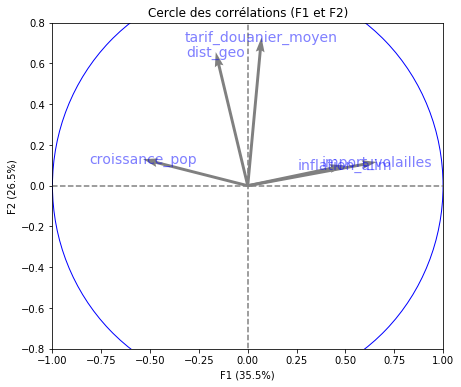

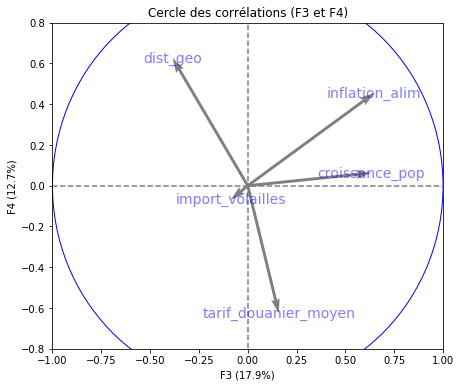

In [350]:
# Affichage du clustering par projection des individus sur le premier plan factoriel
#non affiché car on utilise pas toutes les variables pour effectuer le k-means

# choix du nombre de composantes à calculer
n_comp = 5

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5)], labels = cluster_choisi_k.columns, lims = [-1, 1,-0.80,0.80])

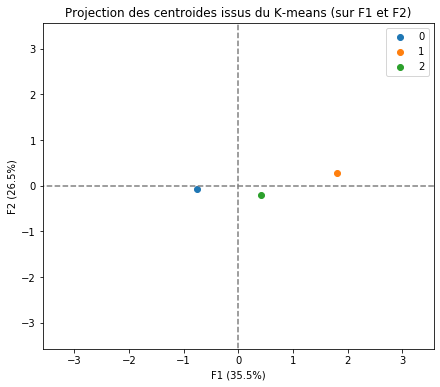

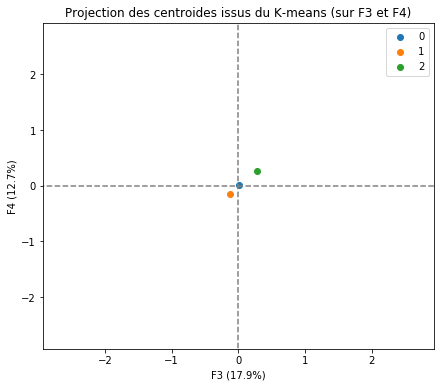

In [351]:
# Affichage centroides k sur les plans factoriels

X_projected = pca.transform(X_scaled)

#calcul des centroides (moyenne des coordonnées des pays du cluster sur chaque plan factoriel)
centroids_k = pd.DataFrame(X_projected)
centroids_k['Cluster K'] = clusters_k
centroids_k = centroids_k.groupby(['Cluster K']).mean()
centroids_k = centroids_k.values

#affichage sur les 3 premiers plans factoriels
for d1,d2 in [(0,1),(2,3)]:
    # initialisation de la figure       
    fig = plt.figure(figsize=(7,6))
        
    # affichage des points         
    illustrative_var = np.unique(clusters_k)
    for value in np.unique(illustrative_var):
        selected = np.where(illustrative_var == value)
        plt.scatter(centroids_k[selected, d1], centroids_k[selected, d2], alpha=1, label=value)
        plt.legend()
                
    # détermination des limites du graphique
    boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
    plt.xlim([-boundary,boundary])
    plt.ylim([-boundary,boundary])
        
    # affichage des lignes horizontales et verticales
    plt.plot([-100, 100], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-100, 100], color='grey', ls='--')

    # nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
    plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

    plt.title("Projection des centroides issus du K-means (sur F{} et F{})".format(d1+1, d2+1))
    plt.show(block=False)

In [352]:
#on ajoute la colonne Cluster K au df des pays initialement choisis
cluster_choisi_k['Cluster K'] = clusters_k

#affichage des pays par cluster
cluster_choisi_k.reset_index(inplace = True)
cluster_choisi_k.set_index(['Cluster K','Pays'], inplace = True)
cluster_choisi_k.sort_values(by = ['Cluster K', 'Pays'], inplace = True)
cluster_choisi_k

croissance_pop  \
Cluster K Pays                                                                 
0         Australie                                                     4.19   
          Autriche                                                      2.38   
          Danemark                                                      1.20   
          Finlande                                                      0.91   
          Irlande                                                       2.73   
          Islande                                                       1.77   
          Israël                                                        4.96   
          Luxembourg                                                    6.74   
          Norvège                                                       3.00   
          Nouvelle-Zélande                                              2.94   
          Suisse                                                        3.04   
          Suède                                                         2.20   
          États-Unis d'Amérique                                         2.01   
1         Allemagne                                                     1.48   
          Japon                                                        -0.52   
          Pays-Bas                                                      0.76   
          Royaume-Uni de Grande-Bretagne et d'Irlande du ...            1.99   
          Émirats arabes unis                                           2.96   
2         Belgique                                                      1.77   
          Canada                                                        2.99   

                                                              import_volailles  \
Cluster K Pays                                                                   
0         Australie                                                     3043.0   
          Autriche                                                     45022.0   
          Danemark                                                     33812.0   
          Finlande                                                      5433.0   
          Irlande                                                      70413.0   
          Islande                                                       1207.0   
          Israël                                                           0.0   
          Luxembourg                                                    7521.0   
          Norvège                                                        526.0   
          Nouvelle-Zélande                                                 0.0   
          Suisse                                                       33791.0   
          Suède                                                        52918.0   
          États-Unis d'Amérique                                        58075.0   
1         Allemagne                                                   474951.0   
          Japon                                                       569477.0   
          Pays-Bas                                                    358733.0   
          Royaume-Uni de Grande-Bretagne et d'Irlande du ...          366960.0   
          Émirats arabes unis                                         417158.0   
2         Belgique                                                    212149.0   
          Canada                                                      143243.0   

                                                              dist_geo  \
Cluster K Pays                                                           
0         Australie                                           16975.46   
          Autriche                                             1035.14   
          Danemark                                             1027.61   
          Finlande                                             1911.14   
          Irlande                                   

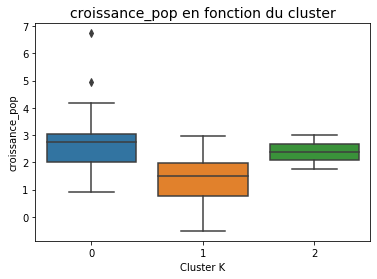

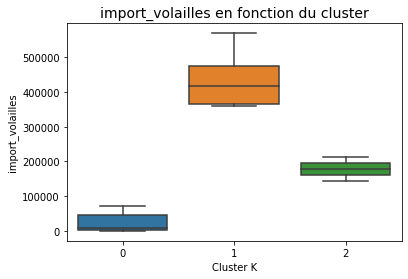

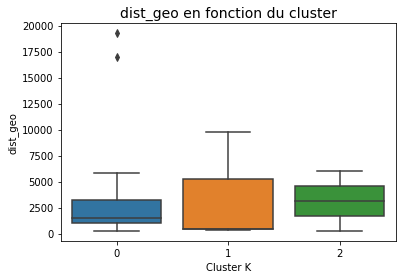

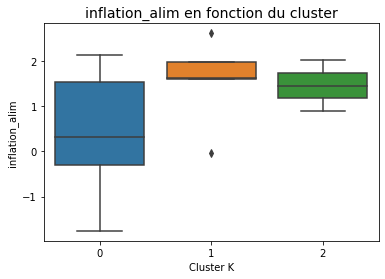

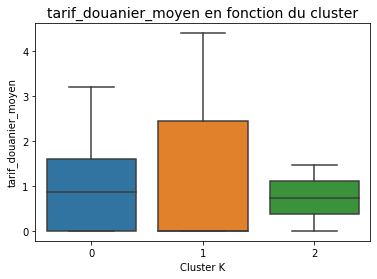

In [353]:
#Boxplot par cluster (1 boxplot par variable)

cluster_choisi_k.reset_index(inplace = True)

for c in cluster_choisi_k.columns[2:]:
    fig, ax = plt.subplots()
    sns.boxplot(data = cluster_choisi_k, x = 'Cluster K', y = c)
    plt.title(f'{c} en fonction du cluster', size = 14)

plt.show()

In [354]:
#affichage short list finale cluster_choisi_k
cluster_choisi_k.set_index('Cluster K', inplace = True)
selection_finale = cluster_choisi_k.loc[[1]]
selection_finale.rename(columns = {'Cluster K': 'Cluster K-means'}, inplace = True)
selection_finale

,Pays,croissance_pop,import_volailles,dist_geo,inflation_alim,tarif_douanier_moyen
Cluster K,,,,,,
1,Allemagne,1.48,474951.0,439.90,1.97,0.00
1,Japon,-0.52,569477.0,9725.63,2.61,2.45
1,Pays-Bas,0.76,358733.0,427.92,1.60,0.00
1,Royaume-Uni de Grande-Bretagne et d'Irlande du...,1.99,366960.0,342.95,-0.03,0.00
1,Émirats arabes unis,2.96,417158.0,5249.54,1.63,4.40


# TESTS STATISTIQUES

## Test d'adequation à la loi normale

Test de Kolmogorov Smirnov: Ks_2sampResult(statistic=0.09036144578313253, pvalue=0.508120453637707)


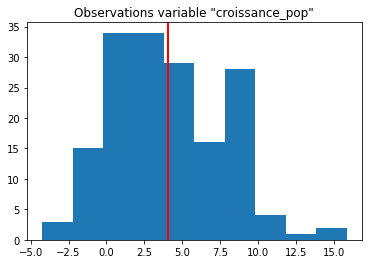

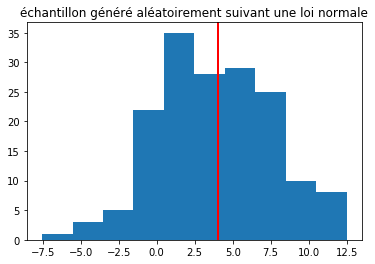

In [355]:
#Kolmogorov Smirnov et Shapiro-Wilk

#echantillon à tester:
variable = 'croissance_pop'
echantillon = data[variable]
xbar = echantillon.mean()


#tests
print('Test de Kolmogorov Smirnov:', st.ks_2samp(echantillon,list(np.random.normal(np.mean(echantillon), np.std(echantillon),
                                                                                   echantillon.count()))))
#print('Test de Kolmogorov Smirnov(kstest):', st.kstest(echantillon, 'norm'))
#print('Test de Shapiro-Wilk:', st.shapiro(echantillon))

#histogrammes
plt.hist(echantillon)
plt.axvline(xbar, color='r', linewidth=2)
plt.title('Observations variable "croissance_pop"')
plt.show()

plt.hist(list(np.random.normal(np.mean(echantillon), np.std(echantillon), echantillon.count()))) #loi normale avec les parametres de la variable testée
plt.axvline(xbar, color='r', linewidth=2)
plt.title('échantillon généré aléatoirement suivant une loi normale')
plt.show()

## Test de comparaison entre 2 clusters issus de la partition

In [356]:
#on choisit les clusters à comparer
data_cluster[['Pays', 'Cluster']].groupby('Cluster').count()

,Pays
Cluster,
1,17
2,20
3,61
4,2
5,50
6,16


In [357]:
#on choisit les 2 clusters les plus grands
cluster_a = data_cluster[data_cluster['Cluster'] == 3][variable]
cluster_b = data_cluster[data_cluster['Cluster'] == 5][variable]

In [358]:
#TEST DU RATIO DES VARIANCES
#Test de Bartlett (on peut utiliser Levene si les échantillons sont trop éloignés d'une distrib gaussienne)

st.bartlett(cluster_a, cluster_b)

BartlettResult(statistic=2.2968736198948556, pvalue=0.12963469608994893)

In [359]:
#TEST D'EGALITE DES MOYENNES
#t-test sur les moyennes

st.ttest_ind(cluster_a, cluster_b)

Ttest_indResult(statistic=6.53564825801227, pvalue=2.0975723517805163e-09)

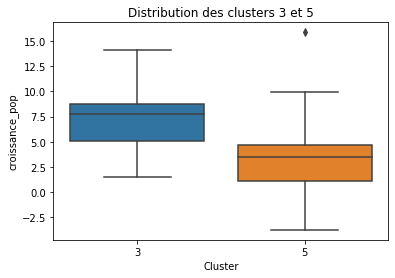

In [360]:
#boxplot des deux clusters étudiés
sns.boxplot(data = data_cluster[data_cluster['Cluster'].isin([3,5])], x = 'Cluster' , y = 'croissance_pop')
plt.title('Distribution des clusters 3 et 5')
plt.show()